<a href="https://colab.research.google.com/github/xchen35/Model_Imagenet32/blob/master/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.engine.topology import get_source_inputs
from keras.layers import DepthwiseConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,regularizers
import numpy as np
from skimage.transform import resize
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [0]:
#base setup
batch_size = 64
num_classes = 500
epochs = 20
num_predictions = 20
weight_decay=1e-4

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

In [0]:
def load_data(data_dir, negatives=False):
    """
    Return train_data, train_labels, test_data, test_labels
    """

    # training data
    train_data = None
    train_labels = []

    # train_data_dict

    for i in range(1, 11):
        train_data_dict = unpickle(data_dir + "/train_data_batch_{}".format(i))
        if i == 1:
            train_data = train_data_dict['data']
        else:
            train_data = np.vstack((train_data, train_data_dict['data']))
#         train_filenames += train_data_dict[b'filenames']
        train_labels += train_data_dict['labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    print(len(train_data))
    if negatives:
        train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        train_data = np.rollaxis(train_data, 1, 4)
#     train_filenames = np.array(train_filenames)
    train_labels = np.array(train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'labels': list

    test_data_dict = unpickle(data_dir + "/val_data")
    test_data = test_data_dict['data']
    test_labels = test_data_dict['labels']

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    if negatives:
        test_data = test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, \
           test_data, test_labels

In [6]:
# The data, split between train and test sets:
x_train, y_train, x_test, y_test = \
        load_data('/content/drive/My Drive/out_data_train')
# print('x_train shape:', x_train.shape)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

100000
x_train shape: (100000, 32, 32, 3)
y_train shape: (100000,)
x_test shape: (2009, 32, 32, 3)
y_test shape: (2009,)


In [7]:
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (100000, 1)
y_test shape: (2009, 1)


In [0]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# load data
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

In [0]:
def depthwise_separable(x,params):
    # f1/f2 filter size, s1 stride of conv
    (s1,f2) = params
    x = DepthwiseConv2D((3,3),strides=(s1[0],s1[0]), padding='same',depthwise_initializer="he_normal")(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(f2[0]), (1,1), strides=(1,1), padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

In [0]:
def MobileNet(img_input, alpha=1, shallow=False, classes=10):
    
    x = Conv2D(int(32), (3,3), strides=(2,2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = depthwise_separable(x,params=[(1,),(64,)])
    x = depthwise_separable(x,params=[(2,),(128,)])
    x = depthwise_separable(x,params=[(1,),(128,)])
    x = depthwise_separable(x,params=[(2,),(256,)])
    x = depthwise_separable(x,params=[(1,),(256,)])
    x = depthwise_separable(x,params=[(2,),(512,)])
    
    if not shallow:
        for _ in range(5):
            x = depthwise_separable(x,params=[(1,),(512,)])
            
    x = depthwise_separable(x,params=[(2,),(1024,)])
    x = depthwise_separable(x,params=[(1,),(1024,)])

    x = GlobalAveragePooling2D()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return out

In [11]:
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
model=Model(img_input,output)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
acti

In [12]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model.save('mobilenet.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1562/1562 [==============================] - 94s 60ms/step - loss: 7.3974 - acc: 0.0160 - val_loss: 7.8037 - val_acc: 0.0080
Epoch 2/20
1562/1562 [==============================] - 87s 56ms/step - loss: 6.3449 - acc: 0.0364 - val_loss: 7.0053 - val_acc: 0.0040
Epoch 3/20
1562/1562 [==============================] - 87s 56ms/step - loss: 5.5175 - acc: 0.0539 - val_loss: 6.7320 - val_acc: 0.0035
Epoch 4/20
1562/1562 [==============================] - 87s 55ms/step - loss: 5.1069 - acc: 0.0635 - val_loss: 6.7324 - val_acc: 0.0035
Epoch 5/20
1562/1562 [==============================] - 87s 56ms/step - loss: 4.9525 - acc: 0.0648 - val_loss: 6.5224 - val_acc: 0.0055
Epoch 6/20
1562/1562 [==============================] - 87s 56ms/step - loss: 4.9658 - acc: 0.0649 - val_loss: 6.5737 - val_acc: 0.0015
Epoch 7/20
1562/1562 [==============================] - 87s 55ms/step - loss: 4.8485 - acc: 0.0749 - val_loss: 6.6050 - val_acc: 0.0040


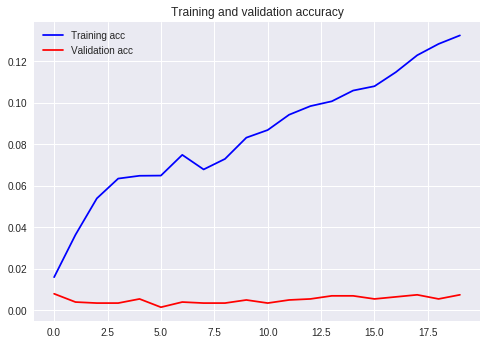

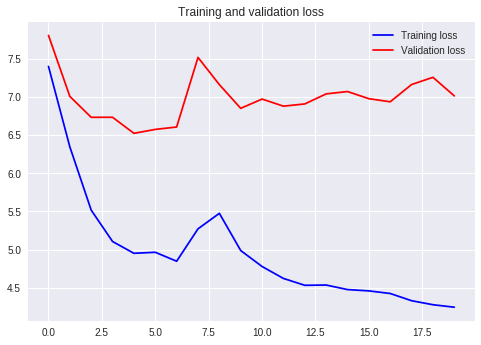

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()